In [45]:
import torch
import torchvision
import torchaudio

In [96]:
 torch.cuda.empty_cache()

In [47]:
torch.__version__

'2.1.1+cu121'

In [48]:
#check for GPU
torch.cuda.is_available()
# device = torch.device('cuda')
# device

True

In [49]:
import numpy as np
import json
import random
import time
from transformers import BertTokenizer

In [50]:
map_relations = {'Comment':0, 'Contrast':1, 'Correction':2, 'Question-answer_pair':3, 'Acknowledgement':4,'Elaboration':5,
                 'Clarification_question':6, 'Conditional':7, 'Continuation':8, 'Result':9, 'Explanation':10, 'Q-Elab':11,
                 'Alternation':12, 'Narration':13, 'Confirmation_question':14, 'Sequence':15, 'Break':16}

In [51]:
reverse_relations = {0:'Comment', 1:'Contrast', 2:'Correction', 3:'Question-answer_pair', 4:'Acknowledgement',5:'Elaboration',
                 6:'Clarification_question', 7:'Conditional', 8:'Continuation', 9:'Result', 10:'Explanation', 11:'Q-Elab',
                 12:'Alternation', 13:'Narration', 14:'Confirmation_question', 15:'Sequence', 16:'Break'}

In [52]:
home=%pwd
# filename = home + '/data/TEST_102_bert.json'
filename = home + '/data/DEV_32_bert.json'

In [53]:
from utils import load_data, input_format, position_ids_compute, tokenize
from bert_format import undersample, format_time, flat_accuracy

In [54]:
test_data = load_data(filename, map_relations)

Loading data: /home/kate/LREC/data/DEV_32_bert.json
32 dialogs, 1860 edus, 2234 relations, 8 backward relations
398 edus have multiple parents


In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', use_fast=True)

In [56]:
put = ['1','0']
colors = ['r', 'b', 'g', 'o', 'y', 'p']
listx = ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n']
listy = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
listz = ['a', 'e', 'i', 'o', 'u', 'p', 'q', 'r', 'x', 'y', 'z']

In [57]:
coord_tokens = [''.join([s, t, i, j, k]) for s in put
                for t in colors
                for i in listx
                for j in listy
                for k in listz]

In [58]:
tokenizer.add_tokens(coord_tokens)

13068

In [59]:
len(tokenizer)

42064

In [60]:
device = torch.device('cuda')

In [61]:
inputs, labels_input, raw = input_format(test_data, 10, relations=True)

relation types only...
2202 relations/candidates


In [62]:
labels_input[:3]

[[0, 0, 1, 8], [0, 1, 2, 8], [0, 2, 3, 4]]

In [63]:
num_labels = len(set([r[3] for r in labels_input]))

In [64]:
num_labels = 17

In [65]:
batch_tokenized = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)

In [66]:
input_ids = batch_tokenized["input_ids"].to(device) # list of token ids of dialogs in batch
attention_masks = batch_tokenized["attention_mask"].to(device)
token_type_ids = batch_tokenized["token_type_ids"].to(device)

In [67]:
labels = [label[3] for label in list(labels_input)]
labels = torch.tensor(labels)
labels_relation = torch.tensor(labels_input)

In [68]:
position_ids = position_ids_compute(tokenizer, input_ids, raw, labels_relation)

In [69]:
position_ids = torch.tensor(position_ids)

In [70]:
task_ids = torch.Tensor([1 for i in range(len(input_ids))])

In [71]:
from multitask_format import MultiTaskModel, Task

In [72]:
model_path = home + '/models/'

In [73]:
attach_task = Task(id = 0, name = 'attach prediction', type = "seq_classification", num_labels=2)
relation_task = Task(id = 1, name = 'relation prediction', type = "seq_classification", num_labels = num_labels)
tasks = [attach_task, relation_task]

model = MultiTaskModel('bert-base-cased', tasks, len(tokenizer))
output_model = model_path + 'multitask_d10.pth'
print(output_model)
checkpoint = torch.load(output_model, map_location='cuda')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print('loaded')

/home/kate/LREC/models/multitask_d10.pth
loaded


Prediction on linear predicted attachments

In [74]:
import pickle
data_path = home + '/pickles/'

In [75]:
with open(data_path + 'MT_input_d10_DEV.pkl', 'rb') as f:
    test_pred = pickle.load(f)

input_ids, labels, raw = input_format(test_data, 10, relations=True, attach_preds=test_pred)
batch_tokenized = tokenizer(input_ids, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)
input_ids = batch_tokenized["input_ids"].to(device) # list of token ids of dialogs in batch
attention_masks = batch_tokenized["attention_mask"].to(device)
token_type_ids = batch_tokenized["token_type_ids"].to(device)

position_ids = position_ids_compute(tokenizer, input_ids, raw, labels)
position_ids = torch.tensor(position_ids)

task_ids = torch.Tensor([1 for i in range(len(input_ids))])

relation types only...
2021 relations/candidates


In [76]:
len(test_pred)

32

In [77]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [78]:
prediction_data = TensorDataset(input_ids, attention_masks, token_type_ids, position_ids, task_ids)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=32)


model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_token_types, b_position_ids, b_task_ids = batch

    with torch.no_grad():
        outputs, embed = model(b_input_ids,
                     token_type_ids=b_token_types,
                     attention_mask=b_input_mask,
                     position_ids = b_position_ids,
                     task_ids = b_task_ids)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    predictions.append(logits)

print('    DONE.')

flat_prediction = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_prediction, axis=1).flatten()

    DONE.


In [79]:
flat_predictions[:10]

array([8, 5, 4, 0, 3, 4, 2, 1, 2, 9])

In [80]:
#add predictions to test pred attachments
#make sure to keep all gold relations, even if not in predicted
preds = []
gold = []
i = 0
for n, g in enumerate(test_pred):
  pred_tmp = []
  gold_tmp = []
  for rel in test_data[n]['relations']:
    # if [rel['x'], rel['y']] in g:
    #   gold_tmp.append([rel['x'], rel['y'], rel['type']])
    if abs(rel['y']-rel['x']) < 11:
      gold_tmp.append([rel['x'], rel['y'], rel['type']])
  for p in g:
    f = flat_predictions[i]
    i += 1
    pred_tmp.append([p[0], p[1], f])
  gold.append(gold_tmp)
  preds.append(pred_tmp)

In [81]:
len(test_pred[0])

61

In [82]:
#now preds is a list of lists of all the predicted relations on predicted attachments
#and gold is a list of lists of all *gold* relations on predicted attachments
len(preds), len(gold)

(32, 32)

In [83]:
len(preds[0]), len(gold[0])

(61, 62)

In [84]:
#now we have to put them together so that in one place we have
# dialogue index | x | y | gold relation (16 if not there)|pred relation
comparisons = []
for game in list(range(len(gold))):
  goldgame = gold[game]
  predgame = preds[game]
  gold_attach = {(g[0], g[1]): g[2] for g in goldgame}
  pred_attach = {(g[0], g[1]) : g[2] for g in predgame}
  true_pos = [e for e in gold_attach.keys() if e in pred_attach.keys()]
  false_pos = [e for e in pred_attach.keys() if e not in gold_attach.keys()]
  false_neg = [e for e in gold_attach.keys() if e not in pred_attach.keys()]
  print('{} false pos attachments in game {}'.format(len(false_pos), game))
  for a in true_pos:
    comparisons.append([game, a[0], a[1], gold_attach[a], pred_attach[a]])
  for b in false_pos:
    comparisons.append([game, b[0], b[1], 16, pred_attach[b]])
  for c in false_neg:
    comparisons.append([game, c[0], c[1], gold_attach[c], 16])

10 false pos attachments in game 0
7 false pos attachments in game 1
6 false pos attachments in game 2
9 false pos attachments in game 3
17 false pos attachments in game 4
9 false pos attachments in game 5
14 false pos attachments in game 6
7 false pos attachments in game 7
3 false pos attachments in game 8
5 false pos attachments in game 9
9 false pos attachments in game 10
19 false pos attachments in game 11
22 false pos attachments in game 12
13 false pos attachments in game 13
11 false pos attachments in game 14
5 false pos attachments in game 15
2 false pos attachments in game 16
17 false pos attachments in game 17
4 false pos attachments in game 18
9 false pos attachments in game 19
20 false pos attachments in game 20
6 false pos attachments in game 21
10 false pos attachments in game 22
9 false pos attachments in game 23
4 false pos attachments in game 24
13 false pos attachments in game 25
5 false pos attachments in game 26
10 false pos attachments in game 27
4 false pos attach

In [85]:
with open(home + '/pickles/' + 'full_scores_multi_d10_DEV.pkl', 'wb') as f:
    pickle.dump(comparisons, f)

In [86]:
pos_comparisons = [c for c in comparisons if c[3] != 16 and c[4] != 16]

In [44]:
comparisons[:2]

[[0, 0, 1, 0, 4], [0, 0, 2, 8, 8]]

In [87]:
correct = [i[3] for i in pos_comparisons]
predicted = [i[4] for i in pos_comparisons]

In [88]:
corr_ = [reverse_relations[i[3]] for i in pos_comparisons]
pred_ = [reverse_relations[i[4]] for i in pos_comparisons]

In [89]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [90]:
print(classification_report(corr_,pred_))

                        precision    recall  f1-score   support

       Acknowledgement       0.94      0.97      0.96       271
           Alternation       1.00      1.00      1.00         4
Clarification_question       0.95      0.83      0.88        46
               Comment       0.74      0.60      0.66        67
           Conditional       0.67      0.80      0.73         5
 Confirmation_question       0.96      0.96      0.96        52
          Continuation       0.61      0.51      0.55       104
              Contrast       0.83      0.86      0.85        29
            Correction       0.71      0.65      0.68        52
           Elaboration       0.81      0.87      0.84       261
           Explanation       0.00      0.00      0.00         5
             Narration       0.92      0.96      0.94       136
                Q-Elab       0.33      0.80      0.47         5
  Question-answer_pair       0.96      0.97      0.96        88
                Result       0.97      

/home/kate/miniconda3/envs/bert_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kate/miniconda3/envs/bert_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kate/miniconda3/envs/bert_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

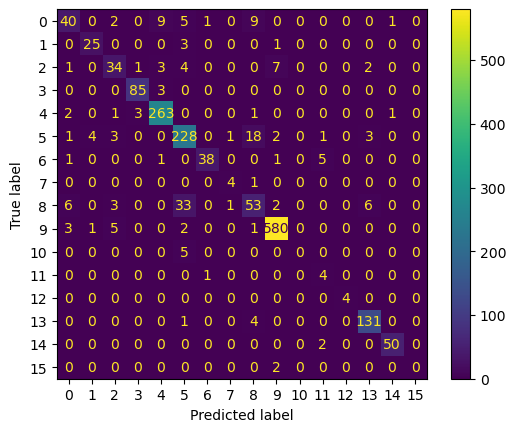

In [91]:
cm = confusion_matrix(correct,predicted)
ConfusionMatrixDisplay(cm).plot()

In [92]:
#all comparisons
correct = [i[3] for i in comparisons]
predicted = [i[4] for i in comparisons]

In [93]:
corr_all = [reverse_relations[i[3]] for i in comparisons]
pred_all = [reverse_relations[i[4]] for i in comparisons]

In [94]:
print(classification_report(corr_all,pred_all))

                        precision    recall  f1-score   support

       Acknowledgement       0.85      0.81      0.83       323
           Alternation       1.00      1.00      1.00         4
                 Break       0.00      0.00      0.00       302
Clarification_question       0.64      0.57      0.60        67
               Comment       0.67      0.50      0.57        80
           Conditional       0.67      0.80      0.73         5
 Confirmation_question       0.93      0.89      0.91        56
          Continuation       0.52      0.41      0.46       129
              Contrast       0.81      0.83      0.82        30
            Correction       0.36      0.29      0.32       116
           Elaboration       0.75      0.81      0.78       282
           Explanation       0.00      0.00      0.00         6
             Narration       0.61      0.48      0.54       274
                Q-Elab       0.25      0.67      0.36         6
  Question-answer_pair       0.77      

/home/kate/miniconda3/envs/bert_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kate/miniconda3/envs/bert_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kate/miniconda3/envs/bert_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

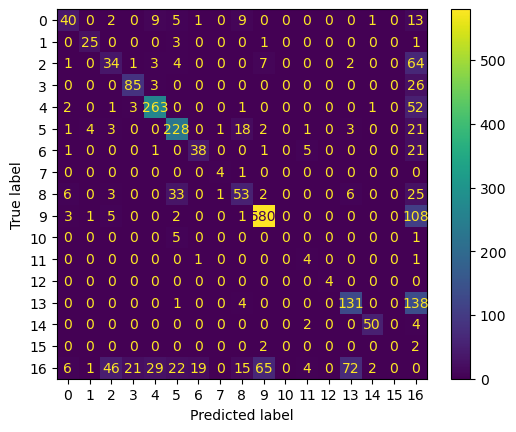

In [95]:
cm = confusion_matrix(correct,predicted)
ConfusionMatrixDisplay(cm).plot()

checking out Narration scores

In [74]:
comparisons[:2]

[[0, 0, 1, 0, 4], [0, 0, 2, 8, 8]]

In [75]:
correct_narrs = [c for c in comparisons if c[3] == 13 and c[4] ==13]

In [80]:
len([i for i in comparisons if i[3] != 13 and i[4] == 13])

242

In [77]:
len(correct_narrs)

305